## Preparando o ambiente

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Carregando o dataframe

df = pd.read_csv('insurance.csv')

# Mostrando as primeiras 5 linhas do dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Verificando características do dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Análise exploratória dos dados

In [5]:
# Trazendo algumas informações do dataset de treino

train.describe()

,age,bmi,children,charges
count,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.357009,30.560397,1.107477,13346.089736
std,14.073960,6.043386,1.215983,12019.510778
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.205000,0.000000,4897.667387
50%,39.500000,30.210000,1.000000,9575.442100
75%,51.000000,34.496250,2.000000,16746.657400
max,64.000000,53.130000,5.000000,62592.873090


In [6]:
# Separando os tipos de variáveis

colunas_numericas = [col for col in train.columns if train[col].dtype == 'int64' or train[col].dtype == 'float64']
colunas_categoricas = [col for col in train.columns if train[col].dtype == 'object']

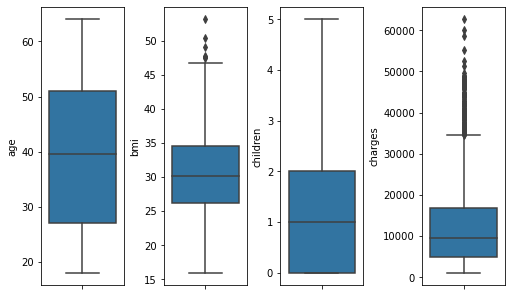

In [7]:
# Vericando a distribuição das variáveis numéricas

fig, ax = plt.subplots(1, 4, layout='constrained', figsize=(7,4))

for i in range(4):
    sns.boxplot(data=train, y=train[colunas_numericas[i]], ax=ax[i])

plt.show()

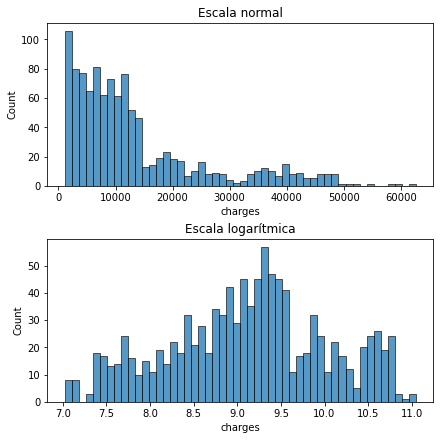

In [8]:
# Verificando a diferença de distribuições em escala linear e logarítmica 

fig, ax = plt.subplots(2, 1, layout='constrained', figsize=(6,6))

sns.histplot(data=train['charges'], bins=50, ax=ax[0]).set_title('Escala normal')
sns.histplot(data=train['charges'], x=np.log1p(train['charges']), bins=50, ax=ax[1]).set_title('Escala logarítmica')

plt.show()

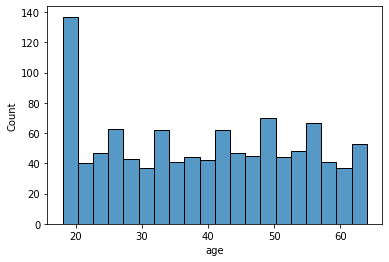

In [9]:
# Verificando a distribuição da idade

sns.histplot(data=train, x=train['age'], bins=20)
plt.show()

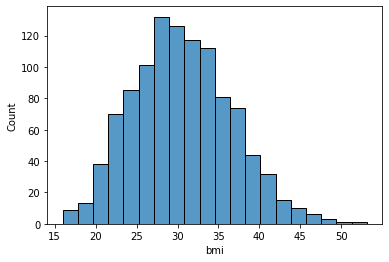

In [10]:
# Verificando a distribuição do índice de massa corporal

sns.histplot(data=train, x=train['bmi'], bins=20)
plt.show()

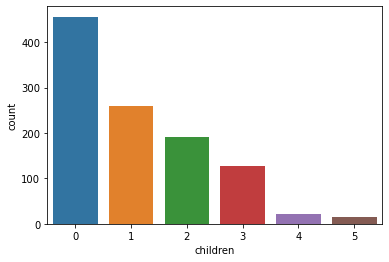

In [11]:
# Verificando a distribuição da idade

sns.countplot(data=train, x=train['children'])
plt.show()

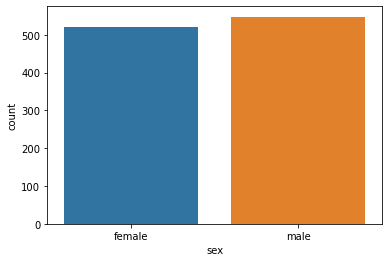

In [12]:
# Verificando a distribuição do sexo

sns.countplot(data=train, x=train['sex'])
plt.show()

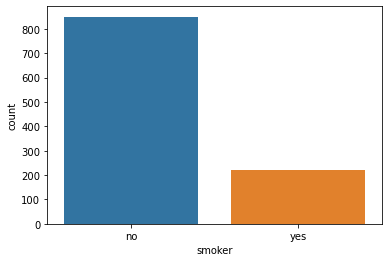

In [13]:
# Verificando a distribuição de fumantes ou não fumantes

sns.countplot(data=train, x=train['smoker'])
plt.show()

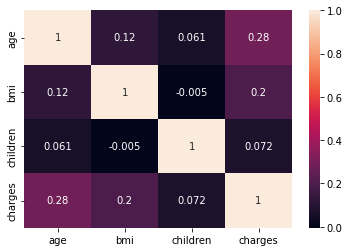

In [14]:
# Verificando a correlação entre as variáveis

sns.heatmap(data=train.corr(), annot=True)
plt.show()

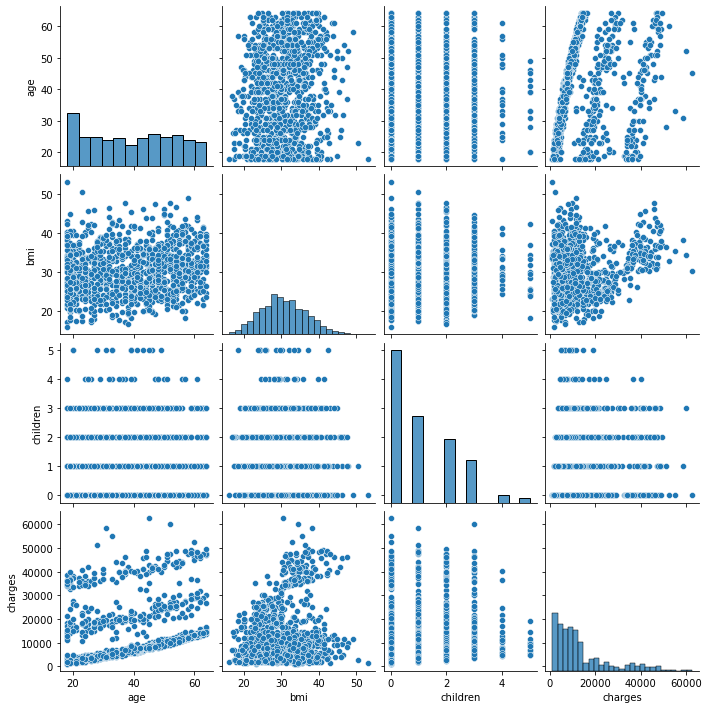

In [15]:
# Verificando a distribuição das variáveis

sns.pairplot(data=train)
plt.show()

## Preparação dos dados

In [16]:
# Separação das bases de treino e teste

X_train = train.drop('charges', axis=1)
y_train = np.log1p(train['charges'])

X_test = test.drop('charges', axis=1)
y_test = np.log1p(test['charges'])

In [17]:
# Checando volumetrias

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 6), (268, 6), (1070,), (268,))

In [18]:
# Criando pipelines para o pré-processamento das variáveis categórias e numéricas

pipeline_num = make_pipeline(
    (MinMaxScaler()))

pipeline_cat = make_pipeline(
    (OneHotEncoder(handle_unknown='ignore', sparse=False))
)

In [19]:
colunas_numericas.remove('charges')

# Definindo em quais colunas o pré-processamento irá atuar
pre_processamento = ColumnTransformer([
    ('cat', pipeline_cat, colunas_categoricas),
    ('num', pipeline_num, colunas_numericas)
])

In [20]:
# Criando um pipeline para regressão linear
pipeline_lr = make_pipeline(
    pre_processamento,
    LinearRegression()
)

# Criando um pipeline para arvore de regressão
pipeline_tree = make_pipeline(
    pre_processamento,
    DecisionTreeRegressor()
)

In [21]:
# Verificando os score de ambos os pipelines.
cv = KFold(n_splits=10, shuffle=True, random_state=42)

print(f'O score para regressão linear é: {cross_val_score(pipeline_lr, X_train, y_train, cv=cv).mean():.3}')
print(f'O score para árvore de regressão é {cross_val_score(pipeline_tree, X_train, y_train, cv=cv).mean():.3}')

O score para regressão linear é: 0.749
O score para árvore de regressão é 0.636


In [22]:
# Verificando o RMSE de ambos os pipelines.
rmse_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error') * -1
rmse_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error') * -1

print(f'O RMSE para regressão linear é: {rmse_lr.mean():.3}')
print(f'O RMSE para árvore de regressão é {rmse_tree.mean():.3}')

O RMSE para regressão linear é: 0.45
O RMSE para árvore de regressão é 0.526


In [23]:
pipeline_lr.fit(X_train, y_train)
pipeline_lr.score(X_test, y_test)

0.8046062566279205

In [27]:
test['predict_charges'] = np.expm1(pipeline_lr.predict(X_test))
test['error'] = abs(test['charges'] - test['predict_charges'])

In [28]:
test.head(30)

,age,sex,bmi,children,smoker,region,charges,predict_charges,error
764,45,female,25.175,2,no,northeast,9095.06825,8898.496668,196.571582
887,36,female,30.020,0,no,northwest,5272.17580,5546.450601,274.274801
890,64,female,26.885,0,yes,northwest,29330.98315,65629.570165,36298.587015
1293,46,male,25.745,3,no,northwest,9301.89355,9109.542150,192.351400
259,19,male,31.920,0,yes,northwest,33750.29180,14164.911373,19585.380427
1312,34,male,42.900,1,no,southwest,4536.25900,6127.486666,1591.227666
899,19,female,22.515,0,no,northwest,2117.33885,2788.433339,671.094489
752,64,male,37.905,0,no,northwest,14210.53595,15256.286939,1045.750989
1286,28,female,17.290,0,no,northeast,3732.62510,3708.862155,23.762945
707,49,male,28.690,3,no,northwest,10264.44210,10567.413785,302.971685


In [33]:
r2_score(y_true=test['charges'], y_pred=test['predict_charges'])

0.6104288033553529